In [ ]:
# location of this script: /glade/u/home/sglanvil/analysis/python/analysis/grid_NCEP.ipynb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pygrib
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp1d

file = "/glade/derecho/scratch/sglanvil/holdingCell/cdas1.t00z.pgrbhanl.nc" # first, I converted it to netcdf
ds = xr.open_dataset(file)
input_variables = {}  
input_variables = {
    'U': ds.UGRD_P0_L100_GLL0,
    'V': ds.VGRD_P0_L100_GLL0,
    'US': ds.UGRD_P0_L100_GLL0,
    'VS': ds.VGRD_P0_L100_GLL0,
    'T': ds.TMP_P0_L100_GLL0,
    'Q': ds.SPFH_P0_L100_GLL0,
    'PS': ds.PRES_P0_L1_GLL0,
    'PHIS_analysis': ds.HGT_P0_L1_GLL0,
    'lon': ds.lon_0,
    'lat': ds.lat_0,
    'lev': ds.lv_ISBL0/100 # note the original data is in Pa
}

# --- file to pull hyai, hybi, hyam, hybm info to define OUTPUT levels
file_lev = "/glade/campaign/cesm/development/cross-wg/S2S/CESM2/CAMI/CFSv2/CESM2_NCEP_0.9x1.25_L32.cam2.i.2023-12-01-00000.nc"
ds = xr.open_dataset(file_lev, decode_times=False)
jerry_variables = {}  
for var_name, var_data in ds.variables.items():
    jerry_variables[var_name] = np.squeeze(var_data)

# --- flip the lat dimension because it currently goes from 90 to -90...
for var_name, var_data in input_variables.items():
    if var_data.ndim == 2:
        var_data = var_data[::-1, :]
    if var_data.ndim == 3:
        var_data = var_data[:, ::-1, :]
    if var_name == 'lat':
        var_data = var_data[::-1]
    input_variables[var_name] = var_data

# --- horizontal interpolation
output_variables = {}
for var_name, var_data in input_variables.items():
    output_variables[var_name] = []
    if var_data.ndim == 2:
        interpolator = RectBivariateSpline(input_variables['lat'], input_variables['lon'], input_variables[var_name][:, :])
        output_variables[var_name] = interpolator(jerry_variables['lat'], jerry_variables['lon'])        
    if var_data.ndim == 3:  
        new_data_list = []
        for level in range(input_variables[var_name].shape[0]):
            interpolator = RectBivariateSpline(input_variables['lat'], input_variables['lon'], input_variables[var_name][level, :, :])
            new_data = interpolator(jerry_variables['lat'], jerry_variables['lon']) # ??? input_variables[var_name] ...or... var_data ???
            new_data_list.append(new_data)
        output_variables[var_name] = np.array(new_data_list)  # ??? ...why must I do this... ???
    if var_data.ndim == 1:
        output_variables[var_name] = jerry_variables[var_name]
        
# --- vertical interpolation
final_variables = {}
for var_name, var_data in output_variables.items():
    print(var_name) # ??? ... why not print(output_variables[var_name]) ... ???
    final_variables[var_name] = []
    if var_data.ndim == 3:
        interpolated_data = np.zeros((len(jerry_variables['lev']), len(jerry_variables['lat']), len(jerry_variables['lon']))) 
        # ??? ... could I just do interpolated_data = [] ... ?
        for i in range(len(jerry_variables['lat'])):
            for j in range(len(jerry_variables['lon'])):
                f = interp1d(input_variables['lev'], output_variables[var_name][:, i, j], kind='nearest', fill_value='extrapolate')
                interpolated_data[:, i, j] = f(jerry_variables['lev'])
        final_variables[var_name] = interpolated_data
    if var_data.ndim < 3:
        final_variables[var_name] = output_variables[var_name]

        

(37, 192, 288)


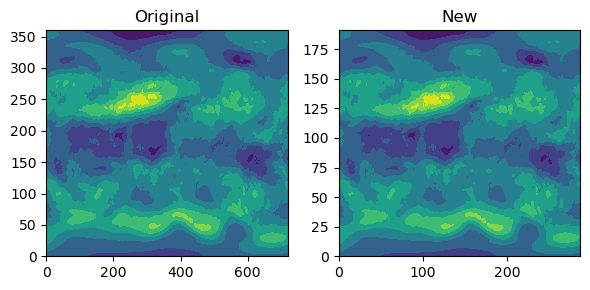

In [150]:
# horizontal (lon,lat) interpolation
# original_lat = lat_0
# original_lon = lon_0
# new_lat = lat
# new_lon = lon
# original_wind = U[:, :, :]
# original_lat_reversed = original_lat[::-1]
# original_wind_reversed = original_wind[:, ::-1, :]

# new_wind_list = []
# for level in range(original_wind.shape[0]):
#     interpolator = RectBivariateSpline(original_lat_reversed, original_lon, original_wind_reversed[level,:,:])
#     new_wind = interpolator(new_lat, new_lon)
#     new_wind_list.append(new_wind)
# new_wind_array = np.array(new_wind_list)
# new_wind_array.shape

# fig, axs = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns
# axs[0].contourf(original_wind_reversed[10, :, :])
# axs[0].set_title('Original')
# axs[1].contourf(new_wind_array[10, :, :])
# axs[1].set_title('New')
# plt.tight_layout()

# print(new_wind_array.shape)

(32, 192, 288)
(37, 361, 720)
(32, 192, 288)
(1, 32, 192, 288)


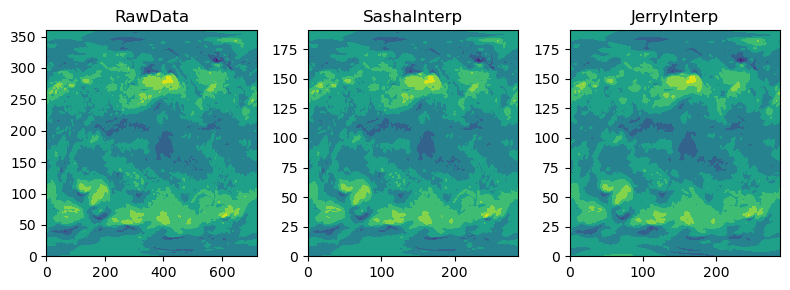

In [171]:
# vertical interpolation
# original_lev = lv_ISBL0/100
# original_lev = original_lev.assign_coords({"lv_ISBL0": original_lev.lv_ISBL0.values/100})
# winds = new_wind_array
# new_lev = lev
# interpolated_winds = np.zeros((len(new_lev), len(new_lat), len(new_lon)))
# for i in range(len(new_lat)):
#     for j in range(len(new_lon)):
#         f = interp1d(original_lev, winds[:, i, j], kind='nearest', fill_value='extrapolate')
#         interpolated_winds[:, i, j] = f(new_lev)

# print(interpolated_winds.shape)

# fig, axs = plt.subplots(1, 3, figsize=(8,3))  # 1 row, 2 columns
# axs[0].contourf(original_wind_reversed[30, :, :])
# axs[0].set_title('RawData')
# axs[1].contourf(interpolated_winds[25, :, :])
# axs[1].set_title('SashaInterp')
# axs[2].contourf(Ujerry[0, 25, :, :])
# axs[2].set_title('JerryInterp')
# plt.tight_layout()

# print(original_wind_reversed.shape)
# print(interpolated_winds.shape)
# print(Ujerry.shape)

In [169]:
print(original_lev.values[30])
print(new_lev.values[25])

850.0
859.5347665250301


In [ ]:
# other notes

# ...if you need to make these coordinates by hand...
# lat = np.linspace(-90, 90, 192)
# lon = np.linspace(0, 360, 289)[:-1]
# slat = lat[:-1] + np.diff(lat)/2
# slon1 = 0 - np.unique(np.diff(lon)/2)
# slon2 = lon[:-1] + np.diff(lon)/2
# slon = np.concatenate((slon1, slon2))

# Yeager's version: /glade/campaign/cesm/development/espwg/JRA55_regridded_to_CAM/tools

# for var in ds.variables:
#     print(var)